# Mini-Flight-Delay

## Pre-processing

In [1]:
import pandas as pd

### Reading dataframe

In [10]:
df = pd.read_csv('../archive/flight_delays_train.csv')

In [11]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


### Function to split values of the first 3 dataframe columns

In [12]:
def split_values(str):
    value = str.split('-')[1]
    return int(value)

### Mapping the values with the split_values function for integers

In [13]:
df['Month'] = df['Month'].map(lambda x: split_values(x))
df['DayofMonth'] = df['DayofMonth'].map(lambda x: split_values(x))
df['DayOfWeek'] = df['DayOfWeek'].map(lambda x: split_values(x))

In [14]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,N
1,4,20,3,1548,US,PIT,MCO,834,N
2,9,2,5,1422,XE,RDU,CLE,416,N
3,11,25,6,1015,OO,DEN,MEM,872,N
4,10,7,6,1828,WN,MDW,OMA,423,Y


In [15]:
print(pd.DataFrame(df.dtypes))

                        0
Month               int64
DayofMonth          int64
DayOfWeek           int64
DepTime             int64
UniqueCarrier      object
Origin             object
Dest               object
Distance            int64
dep_delayed_15min  object


### Mapping columns UniqueCarrier, Origin, Dest
- Mapping values for a dict, and replace them at the dataframe with integers indexes.

In [16]:
# UniqueCarrier
uc_labels = df.UniqueCarrier.unique().tolist()
label_dict_uc_train = {}
for index, possible_label in enumerate(uc_labels):
    label_dict_uc_train[possible_label] = index

# Origin
origin_labels = df.Origin.unique().tolist()
label_dict_origin_train = {}
for index, possible_label in enumerate(origin_labels):
    label_dict_origin_train[possible_label] = index

# Dest
dest_labels = df.Dest.unique().tolist()
label_dict_dest_train = {}
for index, possible_label in enumerate(dest_labels):
    label_dict_dest_train[possible_label] = index

In [17]:
df['UniqueCarrier'] = df.UniqueCarrier.replace(label_dict_uc_train)
df['Origin'] = df.Origin.replace(label_dict_origin_train)
df['Dest'] = df.Dest.replace(label_dict_dest_train)

In [18]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,0,0,0,732,N
1,4,20,3,1548,1,1,1,834,N
2,9,2,5,1422,2,2,2,416,N
3,11,25,6,1015,3,3,3,872,N
4,10,7,6,1828,4,4,4,423,Y


- Our data is quite imbalanced, as we can see below:

In [19]:
df.dep_delayed_15min.value_counts()

N    80956
Y    19044
Name: dep_delayed_15min, dtype: int64

## Exploratory model analysis

We'll explore different models using the Pycaret lib.
- First of all, we'll split our dataset in train and test; for classification tasks, the split is stratified by default.

In [21]:
# para tarefas de classificação, o split é estratificado por padrão
# https://pycaret.org/setup/

data = df.sample(frac=0.75, random_state=786)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (75000, 9)
Unseen Data For Predictions: (25000, 9)


- Initialize a setup with our data.

In [22]:
from pycaret.classification import *
exp_cls101 = setup(data = data, target = 'dep_delayed_15min', session_id=123,
                   numeric_features = ['Month', 'DayofMonth', 'DayOfWeek',
                                       'DepTime', 'UniqueCarrier', 'Origin',
                                       'Dest', 'Distance'], data_split_stratify=True)

,Description,Value
0,session_id,123
1,Target,dep_delayed_15min
2,Target Type,Binary
3,Label Encoded,"N: 0, Y: 1"
4,Original Data,"(75000, 9)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


- Check the perfomance of the some different possible models using the method `compare_methods`.

In [23]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8220,0.7333,0.5515,0.7962,0.7675,0.1505,0.2244,41.1770
lightgbm,Light Gradient Boosting Machine,0.8218,0.7315,0.5435,0.8024,0.7623,0.1301,0.2148,1.0270
rf,Random Forest Classifier,0.8190,0.7161,0.5405,0.7901,0.7596,0.1205,0.1947,5.7320
gbc,Gradient Boosting Classifier,0.8182,0.7173,0.5291,0.7985,0.7514,0.0893,0.1745,9.4410
et,Extra Trees Classifier,0.8167,0.7117,0.5333,0.7825,0.7541,0.1001,0.1703,4.8540
ada,Ada Boost Classifier,0.8131,0.7056,0.5141,0.7725,0.7390,0.0440,0.1062,1.3890
qda,Quadratic Discriminant Analysis,0.8117,0.6793,0.5018,0.7873,0.7283,0.0058,0.0407,0.0480
lr,Logistic Regression,0.8113,0.6820,0.5004,0.7243,0.7270,0.0012,0.0119,2.0820
ridge,Ridge Classifier,0.8112,0.0000,0.5000,0.6581,0.7267,0.0000,0.0000,0.0320
lda,Linear Discriminant Analysis,0.8112,0.6821,0.5003,0.7242,0.7270,0.0011,0.0105,0.0880


- The best performance was achieved by CatBoost, but it is also one of the most heavy models here. As long as its the numbers are very slightely close to the Light Gradient Boosting Machine ones, we go along with LGBM.

In [24]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8217,0.7327,0.5428,0.8024,0.7618,0.1283,0.2134
1,0.8248,0.7393,0.5463,0.8179,0.7649,0.1392,0.2376
2,0.8236,0.7403,0.5471,0.8086,0.7651,0.1406,0.2297
3,0.8198,0.7233,0.5370,0.7976,0.7574,0.1118,0.1947
4,0.8227,0.7356,0.5450,0.8056,0.7635,0.1345,0.2216
5,0.8198,0.7337,0.5405,0.7938,0.7598,0.1210,0.1989
6,0.8246,0.7358,0.5485,0.8127,0.7663,0.1448,0.2372
7,0.8200,0.7223,0.5426,0.7931,0.7612,0.1265,0.2026
8,0.8196,0.7255,0.5400,0.7932,0.7594,0.1196,0.1971
9,0.8215,0.7266,0.5454,0.7985,0.7635,0.1349,0.2149


- We use `tune_model` to tune hyperparameters; it returns is the model setup with greater performance. Under the hood, the function uses a random grid search aproach.

In [26]:
tuned_model = tune_model(lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8240,0.7311,0.5597,0.7994,0.7731,0.1721,0.2437
1,0.8204,0.7296,0.5529,0.7892,0.7679,0.1527,0.2183
2,0.8244,0.7387,0.5658,0.7980,0.7767,0.1866,0.2521
3,0.8147,0.7119,0.5451,0.7725,0.7615,0.1297,0.1826
4,0.8194,0.7327,0.5531,0.7860,0.7677,0.1525,0.2144
5,0.8206,0.7296,0.5534,0.7897,0.7683,0.1541,0.2198
6,0.8230,0.7324,0.5611,0.7954,0.7736,0.1746,0.2407
7,0.8181,0.7193,0.5542,0.7818,0.7680,0.1543,0.2107
8,0.8181,0.7260,0.5511,0.7822,0.7661,0.1467,0.2059
9,0.8188,0.7327,0.5566,0.7837,0.7696,0.1606,0.2172


In [27]:
tuned_model

LGBMClassifier(bagging_fraction=1.0, bagging_freq=1, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.296, max_depth=-1,
               min_child_samples=100, min_child_weight=0.001,
               min_split_gain=0.5, n_estimators=30, n_jobs=-1, num_leaves=150,
               objective=None, random_state=123, reg_alpha=0.01, reg_lambda=5,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

- A very nice feature of Pycaret lib is this performance plot. Here we have the ROC Curve (receiver operating characteristic curve), which plots the True Positive Rates and False Positive Rates at different classification thresholds. Further reading about ROC curves and AOC can be found here:
        - https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc, 
        - https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python, and 
        - https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc

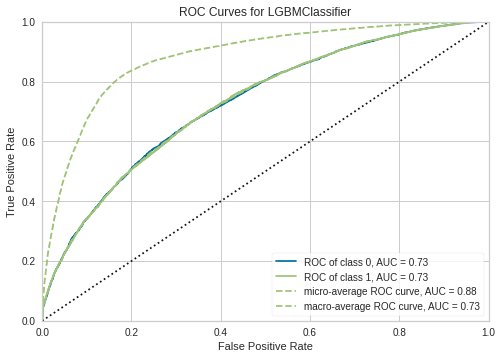

In [28]:
plot_model(tuned_model)

- We can also see the confusion matrix, which shows the absolute numbers of our predictions.

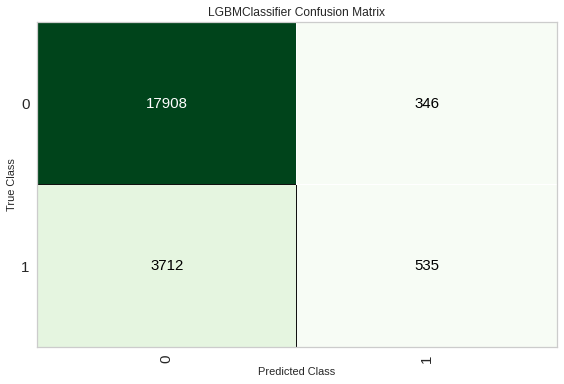

In [29]:
plot_model(tuned_model, plot='confusion_matrix')

- The function `interpret_model` show the most important components for the model output. We can see that the determinant component to state if a flight had a delay, using a LGBM model, is 'departure time'.

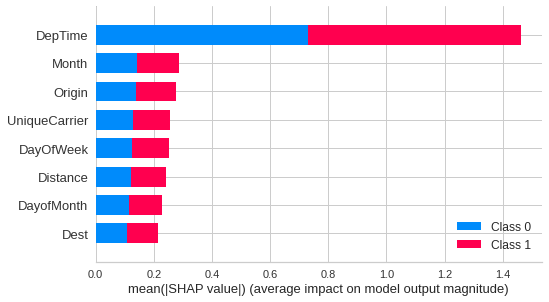

In [30]:
interpret_model(tuned_model)

- Here we have an evaluation on the hold out set.

In [31]:
predictions = predict_model(tuned_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8197,0.7298,0.5535,0.7866,0.7681,0.1538,0.2159


## Generating the predictions for the actual test set

### Preprocessing dataframe values

In [3]:
df_test = pd.read_csv('../archive/flight_delays_test.csv')
df_test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [4]:
df_test['Month'] = df_test['Month'].map(lambda x: split_values(x))
df_test['DayofMonth'] = df_test['DayofMonth'].map(lambda x: split_values(x))
df_test['DayOfWeek'] = df_test['DayOfWeek'].map(lambda x: split_values(x))

In [5]:
df_test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,7,25,3,615,YV,MRY,PHX,598
1,4,17,2,739,WN,LAS,HOU,1235
2,12,2,7,651,MQ,GSP,ORD,577
3,3,25,7,1614,WN,BWI,MHT,377
4,6,6,3,1505,UA,ORD,STL,258


In [6]:
# UniqueCarrier
uc_labels = df_test.UniqueCarrier.unique().tolist()
label_dict_uc_test = {}
for index, possible_label in enumerate(uc_labels):
    label_dict_uc_test[possible_label] = index

# Origin
origin_labels = df_test.Origin.unique().tolist()
label_dict_origin_test = {}
for index, possible_label in enumerate(origin_labels):
    label_dict_origin_test[possible_label] = index

# Dest
dest_labels = df_test.Dest.unique().tolist()
label_dict_dest_test = {}
for index, possible_label in enumerate(dest_labels):
    label_dict_dest_test[possible_label] = index

In [8]:
df_test['UniqueCarrier'] = df_test.UniqueCarrier.replace(label_dict_uc_test)
df_test['Origin'] = df_test.Origin.replace(label_dict_origin_test)
df_test['Dest'] = df_test.Dest.replace(label_dict_dest_test)

In [9]:
df_test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,7,25,3,615,0,0,0,598
1,4,17,2,739,1,1,1,1235
2,12,2,7,651,2,2,2,577
3,3,25,7,1614,1,3,3,377
4,6,6,3,1505,3,4,4,258


In [51]:
df_test

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,7,25,3,615,0,0,0,598
1,4,17,2,739,1,1,1,1235
2,12,2,7,651,2,2,2,577
3,3,25,7,1614,1,3,3,377
4,6,6,3,1505,3,4,4,258
...,...,...,...,...,...,...,...,...
99995,6,5,2,852,1,181,1,187
99996,11,24,6,1446,3,4,39,1515
99997,1,30,2,1509,9,4,147,438
99998,1,5,5,804,11,24,16,761


### Using the trained model to predict on the test dataframe

In [40]:
lgbm_final = finalize_model(lgbm)

In [41]:
test_labels = predict_model(lgbm_final, data = df_test)

In [42]:
test_labels

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Label,Score
0,7,25,3,615,0,0,0,598,N,0.9750
1,4,17,2,739,1,1,1,1235,N,0.9534
2,12,2,7,651,2,2,2,577,N,0.9740
3,3,25,7,1614,1,3,3,377,N,0.7714
4,6,6,3,1505,3,4,4,258,N,0.8416
...,...,...,...,...,...,...,...,...,...,...
99995,6,5,2,852,1,181,1,187,N,0.9185
99996,11,24,6,1446,3,4,39,1515,N,0.7955
99997,1,30,2,1509,9,4,147,438,N,0.8374
99998,1,5,5,804,11,24,16,761,N,0.9334


In [43]:
test_labels = test_labels.drop(['Score'], axis=1)

In [44]:
test_labels

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Label
0,7,25,3,615,0,0,0,598,N
1,4,17,2,739,1,1,1,1235,N
2,12,2,7,651,2,2,2,577,N
3,3,25,7,1614,1,3,3,377,N
4,6,6,3,1505,3,4,4,258,N
...,...,...,...,...,...,...,...,...,...
99995,6,5,2,852,1,181,1,187,N
99996,11,24,6,1446,3,4,39,1515,N
99997,1,30,2,1509,9,4,147,438,N
99998,1,5,5,804,11,24,16,761,N


In [45]:
test_labels.to_csv('hey.csv', index=False)